In [11]:
# https://www.youtube.com/watch?v=NFIYdYjJams
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tqdm import tqdm

METAINFO = {
    "classes": (
        "unlabelled",
        "asphalt",
        "dirt",
        "mud",
        "water",
        "gravel",
        "other-terrain",
        "tree-trunk",
        "tree-foliage",
        "bush",
        "fence",
        "structure",
        "pole",
        "vehicle",
        "rock",
        "log",
        "other-object",
        "sky",
        "grass",
    ),
    "palette": [
        (0, 0, 0),
        (230, 25, 75),
        (60, 180, 75),
        (255, 225, 25),
        (0, 130, 200),
        (145, 30, 180),
        (70, 240, 240),
        (240, 50, 230),
        (210, 245, 60),
        (250, 190, 190),
        (0, 128, 128),
        (170, 110, 40),
        (255, 250, 200),
        (128, 0, 0),
        (170, 255, 195),
        (128, 128, 0),
        (255, 215, 180),
        (0, 0, 128),
        (128, 128, 128),
    ],
    "cidx": list(range(19))
}

# Parameters
IMG_SIZE = 256  # Resized image size
BATCH_SIZE = 8  # Adjust batch size according to available memory
NUM_CLASSES = 19

In [12]:
def load_and_sample_data(file_path, sample_fraction=1):
    df = pd.read_csv(file_path)
    sampled_df = df.sample(frac=sample_fraction, random_state=42)
    return sampled_df

train_df = load_and_sample_data('train.csv')
val_df = load_and_sample_data('val.csv')
test_df = load_and_sample_data('test.csv')

# Data generators for training and validation
def data_generator(df, batch_size, img_size, num_classes):
    while True:
        for start in range(0, len(df), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(df))
            batch_df = df[start:end]
            for _, row in batch_df.iterrows():
                img = cv2.imread(row['im_path'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (img_size, img_size))
                img = img / 255.0
                
                label = cv2.imread(row['label_path'], cv2.IMREAD_GRAYSCALE)
                label = cv2.resize(label, (img_size, img_size))
                label = to_categorical(label, num_classes=num_classes)
                
                x_batch.append(img)
                y_batch.append(label)
            yield np.array(x_batch), np.array(y_batch)

In [13]:
# Data EDA, check unique values in label images, we want to make sure that all classes are in the set of unique values
# def check_unique_values(df):
#     unique_values = set()
#     for _, row in df.iterrows():
#         label = cv2.imread(row['label_path'], cv2.IMREAD_GRAYSCALE)
#         unique_values.update(np.unique(label))
#     return unique_values

# train_unique_values = check_unique_values(train_df)
# val_unique_values = check_unique_values(val_df)
# test_unique_values = check_unique_values(test_df)

# print("Unique values in train labels:", train_unique_values)
# print("Unique values in val labels:", val_unique_values)
# print("Unique values in test labels:", test_unique_values)

# Jaccard coefficient and loss
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [14]:
# U-Net Model
def build_unet_model(img_size, num_classes):
    inputs = Input(shape=(img_size, img_size, 3))
    
    # Downsampling
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Upsampling
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)
    
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [15]:
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(lr_schedule)
train_gen = data_generator(train_df, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)
val_gen = data_generator(val_df, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)

initial_learning_rate = 0.001
model = build_unet_model(IMG_SIZE, NUM_CLASSES)
model.compile(optimizer=Adam(learning_rate=initial_learning_rate), loss='categorical_crossentropy', metrics=[jacard_coef])
model.fit(train_gen, steps_per_epoch=len(train_df) // BATCH_SIZE, epochs=10, validation_data=val_gen, validation_steps=len(val_df) // BATCH_SIZE, callbacks=[lr_scheduler])

test_gen = data_generator(test_df, BATCH_SIZE, IMG_SIZE, NUM_CLASSES)
model.evaluate(test_gen, steps=len(test_df) // BATCH_SIZE)

Epoch 1/10
756/756 [==============================] - 402s 530ms/step - loss: 0.7521 - jacard_coef: 0.4928 - val_loss: 0.5571 - val_jacard_coef: 0.6032 - lr: 0.0010
Epoch 2/10
756/756 [==============================] - 410s 540ms/step - loss: 0.5302 - jacard_coef: 0.5870 - val_loss: 0.4891 - val_jacard_coef: 0.6189 - lr: 0.0010
Epoch 3/10
756/756 [==============================] - 397s 525ms/step - loss: 0.4909 - jacard_coef: 0.6087 - val_loss: 0.4947 - val_jacard_coef: 0.6215 - lr: 0.0010
Epoch 4/10
756/756 [==============================] - 396s 524ms/step - loss: 0.4702 - jacard_coef: 0.6197 - val_loss: 0.4706 - val_jacard_coef: 0.6295 - lr: 0.0010
Epoch 5/10
756/756 [==============================] - 396s 524ms/step - loss: 0.4517 - jacard_coef: 0.6300 - val_loss: 0.4547 - val_jacard_coef: 0.6424 - lr: 0.0010
Epoch 6/10
756/756 [==============================] - 394s 521ms/step - loss: 0.4353 - jacard_coef: 0.6388 - val_loss: 0.4420 - val_jacard_coef: 0.6253 - lr: 9.0484e-04
Epoch 

[0.5019012689590454, 0.6118669509887695]

1/1 [==============================] - 0s 22ms/step


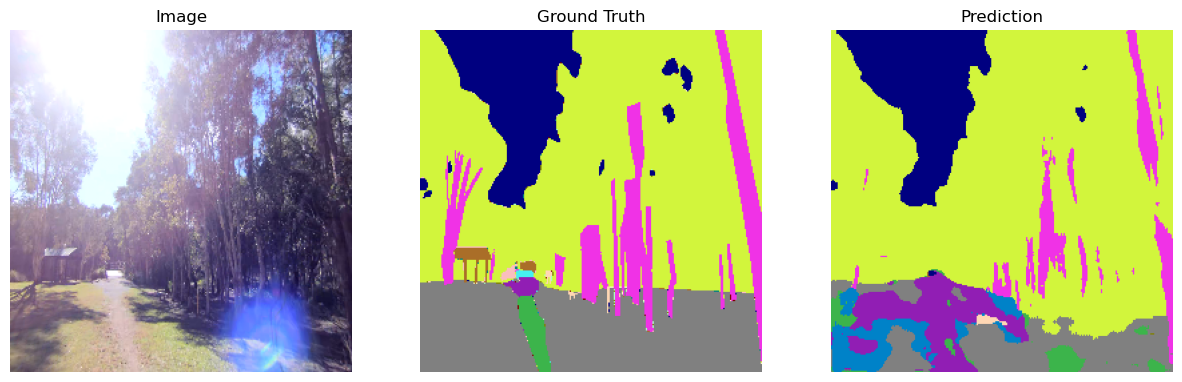

In [16]:
# Predict on a sample image
sample_image, sample_mask = next(data_generator(test_df, 1, IMG_SIZE, NUM_CLASSES))
prediction = model.predict(sample_image)[0]

palette = METAINFO['palette']
def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

sample_image, sample_mask = next(data_generator(test_df, 1, IMG_SIZE, NUM_CLASSES))
prediction = model.predict(sample_image)[0]

def label_to_rgb(label, palette):
    rgb_image = np.zeros((*label.shape, 3), dtype=np.uint8)
    for label_idx, color in enumerate(palette):
        rgb_image[label == label_idx] = color
    return rgb_image

# visualize the sample image, ground truth and prediction
sample_image = sample_image[0]
sample_mask = sample_mask[0]

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(sample_image)
plt.title("Image")
plt.axis('off')

plt.subplot(132)
plt.imshow(label_to_rgb(sample_mask.argmax(axis=2), palette))
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(133)
plt.imshow(label_to_rgb(prediction.argmax(axis=2), palette))
plt.title("Prediction")
plt.axis('off')
plt.show()

In [17]:
# Function to calculate IoU for each class
tf.get_logger().setLevel('ERROR')
def calculate_class_iou(y_true, y_pred, num_classes):
    ious = []
    for cls in range(num_classes):
        true_class = (y_true == cls)
        pred_class = (y_pred == cls)
        
        intersection = np.logical_and(true_class, pred_class).sum()
        union = np.logical_or(true_class, pred_class).sum()
        
        if union == 0:
            iou = np.nan  # If there is no ground truth or prediction for this class, set IoU to NaN
        else:
            iou = intersection / union
        
        ious.append(iou)
    
    return ious

# Function to calculate IoUs for each class
def calculate_class_ious(model, test_df, img_size, num_classes):
    test_gen = data_generator(test_df, 1, img_size, num_classes)
    y_preds = []
    y_trues = []
    
    for _ in range(len(test_df)):
        test_images, test_labels = next(test_gen)
        y_pred = model.predict(test_images)
        y_preds.append(y_pred)
        y_trues.append(test_labels)
        
    y_preds = np.concatenate(y_preds, axis=0)
    y_trues = np.concatenate(y_trues, axis=0)
    
    y_pred_argmax = np.argmax(y_preds, axis=3)
    y_true_argmax = np.argmax(y_trues, axis=3)
    
    class_ious = calculate_class_iou(y_true_argmax, y_pred_argmax, num_classes)
    return class_ious

# Calculate and print IoU for each class
class_ious = calculate_class_ious(model, test_df, IMG_SIZE, NUM_CLASSES)

1/1 [==============================] - 0s 16ms/step


In [18]:
classes = palette = METAINFO['classes']
merged_classes = []
merged_ious = []

for idx, class_name in enumerate(classes):
    if class_name == "pole":
        # Merge pole IoU into other-object
        other_object_idx = classes.index("other-object")
        class_ious[other_object_idx] += class_ious[idx]
    elif class_name == "asphalt":
        # Merge asphalt IoU into other-terrain
        other_terrain_idx = classes.index("other-terrain")
        class_ious[other_terrain_idx] += class_ious[idx]
    elif class_name not in ["vehicle", "pole", "asphalt", "unlabelled"]:
        merged_classes.append(class_name)
        merged_ious.append(class_ious[idx])

class_iou_pairs = list(zip(merged_classes, merged_ious))
sorted_class_iou_pairs = sorted(class_iou_pairs, key=lambda x: x[0])

for class_name, iou in sorted_class_iou_pairs:
    print(f"Class {class_name} IoU: {iou * 100: .2f}")

MIou = np.nanmean(merged_ious)
print(f"Mean IoU: {MIou * 100: .2f}")

Class bush IoU:  13.97
Class dirt IoU:  68.62
Class fence IoU:  0.00
Class grass IoU:  56.67
Class gravel IoU:  0.45
Class log IoU:  12.80
Class mud IoU:  0.00
Class other-object IoU:  25.81
Class other-terrain IoU:  0.00
Class rock IoU:  2.94
Class sky IoU:  77.79
Class structure IoU:  26.86
Class tree-foliage IoU:  83.48
Class tree-trunk IoU:  53.71
Class water IoU:  17.28
Mean IoU:  29.36
